In [1]:
import xarray as xr
import pyorc
from matplotlib.colors import Normalize

In [2]:
ds = xr.open_dataset(R".\artifact\mask.nc", engine="netcdf4")
video_file = R"./artifact/live.mp4"

Scanning video: 100%|██████████| 60/60 [00:00<00:00, 118.18it/s]


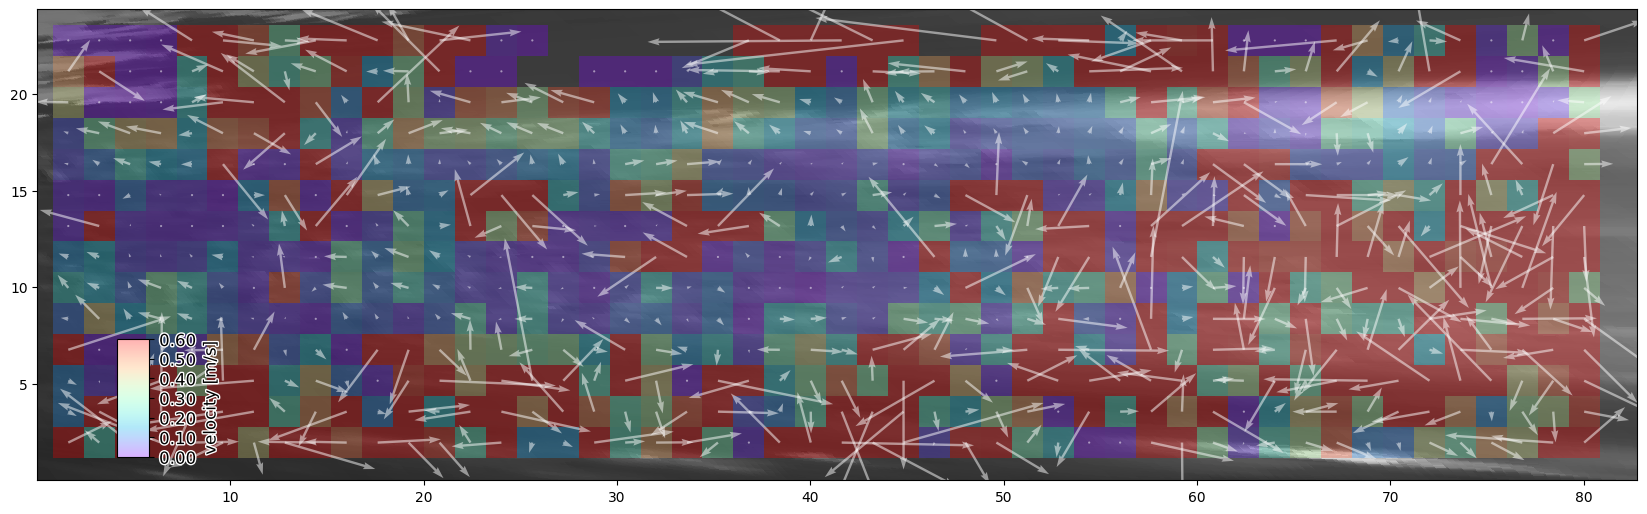

In [3]:
video = pyorc.Video(video_file, start_frame=0, end_frame=125)
video.camera_config = ds.velocimetry.camera_config

da_rgb = video.get_frames(method="rgb")
# project the rgb frame
da_rgb_proj = da_rgb.frames.project()
# plot the first frame (we only have one) without any arguments, default is to use "local" mode
p = da_rgb_proj[0].frames.plot()

ds_mean = ds.mean(dim="time", keep_attrs=True)

ds_mean.velocimetry.plot.pcolormesh(
    ax=p.axes,
    alpha=0.3,
    cmap="rainbow",
    add_colorbar=True,
    vmax=0.6
)

ds_mean.velocimetry.plot(
    ax=p.axes,
    color="w",
    alpha=0.5,
    width=0.0015,
)